Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


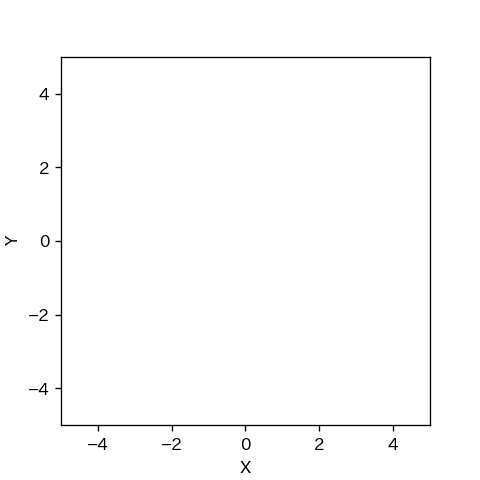

In [1]:
import sys
sys.path.append('../scripts/')
from mcl import *

In [2]:
class ResetMcl(Mcl): ###resetmcl3 （12行目以下）
    def __init__(self, envmap, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, \
                 distance_dev_rate=0.14, direction_dev=0.05, alpha_threshold=0.001): #alpha_thresholdを追加
        super().__init__(envmap, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.alpha_threshold = alpha_threshold #追加
        
    def random_reset(self):
         for p in self.particles:
                p.pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
                p.weight = 1/len(self.particles)
                
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs): #追加
            ##パーティクルの位置を決める##
            psi = np.random.uniform(-np.pi, np.pi) #ランドマークからの方角を選ぶ
            ell = norm(loc=ell_obs, scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
            particle.pose[0] = landmark_pos[0] + ell*math.cos(psi)
            particle.pose[1] = landmark_pos[1] + ell*math.sin(psi)
            
            ##パーティクルの向きを決める##
            phi = norm(loc=phi_obs, scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
            particle.pose[2] = math.atan2(landmark_pos[1]- particle.pose[1], landmark_pos[0]- particle.pose[0]) - phi
            
            particle.weight = 1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self, observation): #追加
        nearest_obs = np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id = observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p, self.map.landmarks[landmark_id].pos, *values)
        
    def observation_update(self, observation):        
        for p in self.particles:
            p.observation_update(observation, self.map, self.distance_dev_rate, self.direction_dev) 
            
        self.set_ml()

        if sum([p.weight for p in self.particles]) < self.alpha_threshold: 
            self.sensor_resetting(observation) #sensor_resettingに変更
        else:
            self.resampling() 

In [3]:
def trial_trap(animation): ###mclkidnap1test
    time_interval = 0.1
    world = World(30, time_interval, debug=not animation) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)

    ## ロボットを作る ##
    init_pose = np.array([0,0,0]).T
    robot_pose = np.array([0,0,0]).T
    pf = ResetMcl(m, init_pose, 100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m), agent=a, color="red",expected_stuck_time=5,expected_escape_time=5)
    world.append(r)

    world.draw()
    
    return (r.pose, pf.ml.pose)

In [4]:
if __name__ =='__main__':
    ok=0
    for i in range(1000):
        actual, estm=trial_trap(False)
        diff=math.sqrt((actual[0]-estm[0])**2+(actual[1]-estm[1])**2)
        print(i,"真値:",actual,"推定値:",estm,"誤差:",diff)
        if diff<=1.0:
            ok+=1
            print(ok)

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


0 真値: [-0.62878587  1.5752553   3.84787516] 推定値: [-0.93431693  1.30162682  3.63698435] 誤差: 0.4101484738859768
1
1 真値: [-0.12622697  2.00479181  3.40568548] 推定値: [-0.61863565  1.90904223  3.31300078] 誤差: 0.5016316208153474
2
2 真値: [-0.62738297  2.27033042  3.82051782] 推定値: [-0.57595725  1.72973953  3.61278341] 誤差: 0.5430314077969082
3
3 真値: [1.15998959 2.22948486 2.17311933] 推定値: [0.66397068 3.15906811 2.41640716] 誤差: 1.0536412027955484
4 真値: [-0.2967224   2.627091    3.20505881] 推定値: [0.16952566 2.31501095 3.08302445] 誤差: 0.5610536574803
4
5 真値: [1.28700529 1.06092854 1.37954735] 推定値: [3.04170449 0.41956814 2.19131141] 誤差: 1.86823779608349
6 真値: [-0.91551743  0.95829219  4.36080538] 推定値: [-0.86225254  0.87177442  4.40135656] 誤差: 0.10159957211701806
5
7 真値: [-1.12364793  1.92893091  4.10422394] 推定値: [-1.27727287  2.09584146  4.08694911] 誤差: 0.22684742278531167
6
8 真値: [-0.23999535  2.13080287  3.65259405] 推定値: [-1.10042971  2.65444566  3.85967924] 誤差: 1.0072482573468169
9 真値: [0.9597874

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [0.98378371 2.33671554 2.31784889] 推定値: [0.92736621 1.95988858 2.1649615 ] 誤差: 0.38102689163027714
15
21 真値: [-0.13188979  2.08255695  3.45151612] 推定値: [-0.3356606   2.10180487  3.49378639] 誤差: 0.20467785647096146
16
22 真値: [1.15643772 1.89619033 2.19250642] 推定値: [-8.12682508 -3.49507991  0.07198443] 誤差: 10.735211360319356
23 真値: [-0.67174116  1.91050054  4.1385031 ] 推定値: [-0.74739004  1.99563981  4.17395407] 誤差: 0.11389226964000602
17
24 真値: [-0.53763003  2.65488263  3.58530214] 推定値: [-0.33933509  2.29088524  3.42327257] 誤差: 0.41450570977737633
18
25 真値: [0.30809352 2.61671416 3.13953576] 推定値: [-1.02180182  3.95603111  3.50142945] 誤差: 1.8874298620904766
26 真値: [0.12618539 2.12041844 3.15541641] 推定値: [-0.93387894  2.74874059  3.39805762] 誤差: 1.232284505831987
27 真値: [0.17252984 2.49858258 2.74957127] 推定値: [-0.55073053  3.09390776  2.85530729] 誤差: 0.936759104140012
19
28 真値: [1.15850918 0.61120543 0.97309765] 推定値: [1.83201947 0.67889754 1.14701534] 誤差: 0.6769034858657161
20
29 真値